In [127]:
import sys
#!{sys.executable} -m pip uninstall rasterio
#!{sys.executable} -m pip install --pre -U rasterio
#!{sys.executable} -m pip install affine
#!{sys.executable} -m pip install fiona
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install mplleaflet

In [120]:
import sys
import os
import json
import scipy
#import urllib
#import datetime 
#import urllib3
import rasterio
from affine import Affine
import fiona
#import subprocess
import numpy as np
import pandas as pd
#import seaborn as sns
from osgeo import gdal
#from planet import api
#from planet.api import filters
#from traitlets import link
#import rasterio.tools.mask as rio_mask
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform

In [3]:
with rasterio.open("/Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS.tif") as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)

8348 4089
+init=epsg:32756
| 3.00, 0.00, 499158.00|
| 0.00,-3.00, 6888087.00|
| 0.00, 0.00, 1.00|
4
(1, 2, 3, 4)


In [59]:
# FRom: https://github.com/kscottz/PythonFromSpace/blob/master/TheBasics.ipynb
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])

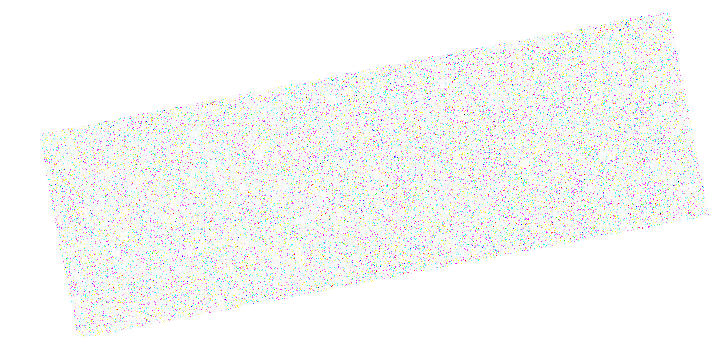

In [61]:
fb = load_image4("/Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS.tif")
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(fb)
plt.show()

In [8]:
with open('/Users/brian/code/planet/20180815_003119_100d/geojson2.json') as data_file:    
    geoms= json.load(data_file)
print(geoms)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[153.06092806892707, -28.168908766719408], [153.03792544441535, -28.16898443157287], [153.0377537830384, -28.199170437120817], [153.06101389961555, -28.19909479362476], [153.06092806892707, -28.168908766719408]]]}, 'properties': {}}]}


In [9]:
g = geoms.get('geometry')
print(g)

None


In [21]:
with fiona.open("/Users/brian/code/planet/20180815_003119_100d/geojson2.json", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
    
print(geoms)

[{'type': 'Polygon', 'coordinates': [[(153.06092806892707, -28.168908766719408), (153.03792544441535, -28.16898443157287), (153.0377537830384, -28.199170437120817), (153.06101389961555, -28.19909479362476), (153.06092806892707, -28.168908766719408)]]}]


In [62]:
fb.shape

(4089, 8348, 4)

In [67]:
rs = transform.rescale(fb, 5/10) # this is skimage.transform
rs.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(2044, 4174, 4)

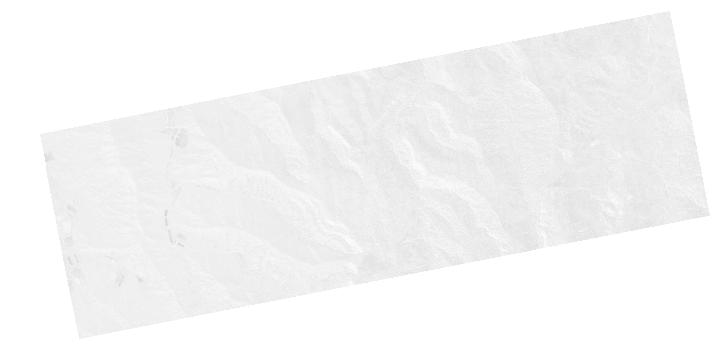

In [68]:
#rs = transform.rescale(fb, 5/10) # this is skimage.transform
#rs.shape
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(rs)
plt.show()

In [69]:
# A function to calculate ECARR index, substituting LS8 Band 3 for Modis Band 1:
def calc_ecarr_using_band1(data_ecarr):
    #data_ecarr = img.read([3,2]).astype(np.float32)
    lsband4 = data_ecarr[:,:,3] * 4.25585456224e-05 # 3 Red
    lsband3 = data_ecarr[:,:,2] * 2.85577526769e-05 # 2 Green

    # Renaming Landsat8 bands to MODIS bands:
    band1 = lsband4
    band4 = lsband3
    ecarr = 0.0161 * ((band1 / (band4 * band1) ) ** 0.7784)
    return(ecarr)

In [93]:
# A function to calculate NDVI:
def calc_nvdi(data_ecarr):
    #data_ecarr = img.read([3,2]).astype(np.float32)
    red = data_ecarr[:,:,0] * 2.42173976186e-05
    nir = data_ecarr[:,:,3] * 4.25585456224e-05
    nvdi = (nir - red)/(nir+red)
    return(nvdi)

# A function to calculate NDWI:
def calc_nwdi(data_ecarr):
    green = data_ecarr[:,:,2] * 2.42173976186e-05
    nir = data_ecarr[:,:,3] * 4.25585456224e-05
    nvdi = (green - nir )/(nir+green)
    return(nvdi)

In [66]:
# above, I have manually grabbed reflectance normalizing values.  Should do something like this:
from xml.dom import minidom

xmldoc = minidom.parse("/Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

In [67]:
print(coeffs)

{1: 2.42173976186e-05, 2: 2.56164546152e-05, 3: 2.85577526769e-05, 4: 4.25585456224e-05}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


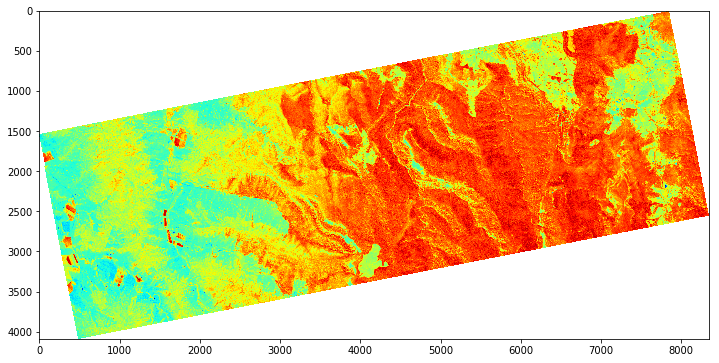

In [63]:
f, ax = plt.subplots(1, figsize=(12,24))
#t = calc_ecarr_using_band1(fb)
t = calc_nvdi(fb)
plt.set_cmap('jet')
plt.imshow(t)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


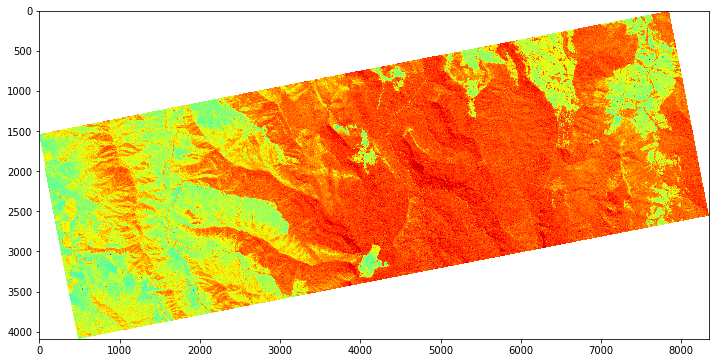

In [70]:
f, ax = plt.subplots(1, figsize=(12,24))
t = calc_ecarr_using_band1(fb)
#t = calc_nvdi(fb)

plt.set_cmap('jet')
plt.imshow(t)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


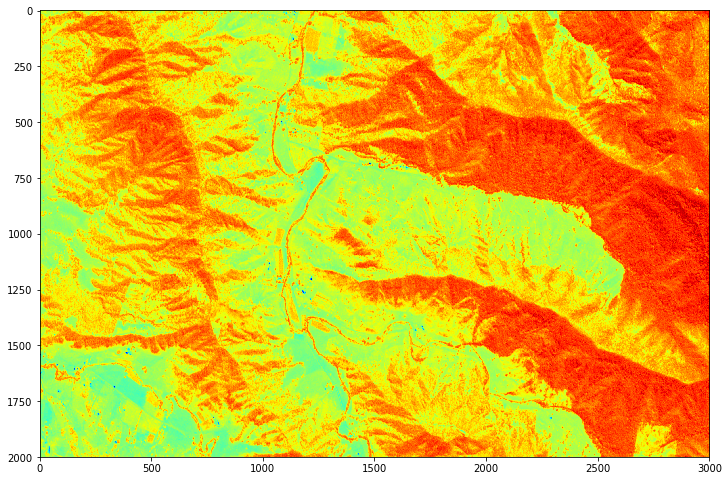

In [84]:
f, ax = plt.subplots(1, figsize=(12,24))
nrs = fb[1500:3500,500:3500]
nrs.shape
t = calc_ecarr_using_band1(nrs)
plt.set_cmap('jet')
plt.imshow(t)
plt.show()

In [ ]:
Note that ECARR seems to pick up water strongly.  Perhaps some way to subtract NDWI from ECARR?
Likewise, someway to modulate ECARR with NVDI?

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


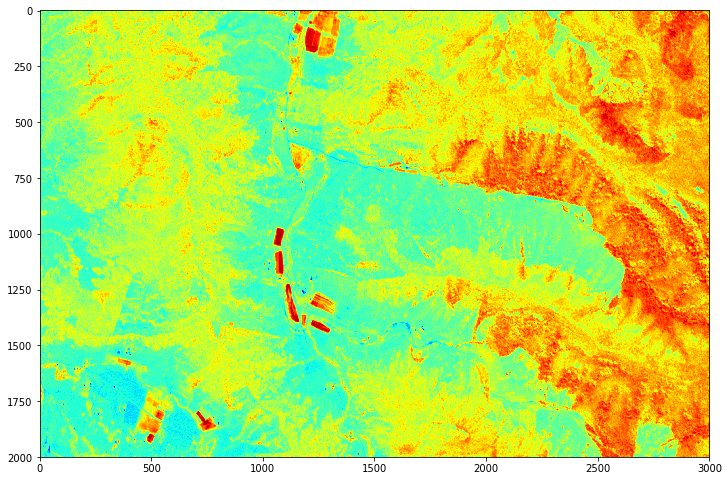

In [85]:
f, ax = plt.subplots(1, figsize=(12,24))
nrs = fb[1500:3500,500:3500]
#nrs.shape
t = calc_nvdi(nrs)
plt.set_cmap('jet')
plt.imshow(t)
plt.show()

In [74]:
#rs = transform.rescale(fb, 5/10) # this is skimage.transform

nrs = fb[2000:3000,1000:2000]
nrs.shape

(1000, 1000, 4)

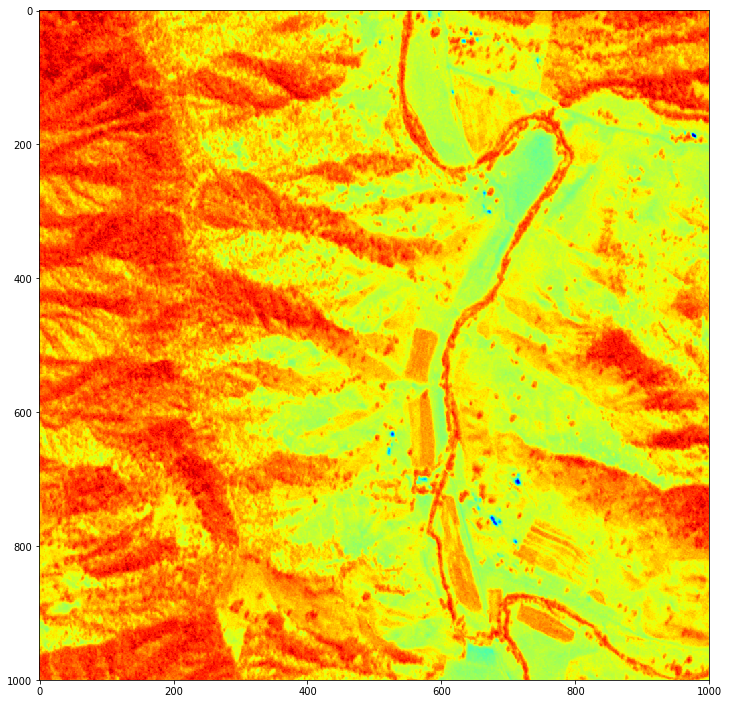

In [75]:
f, ax = plt.subplots(1, figsize=(12,24))
t = calc_ecarr_using_band1(nrs)
#t = calc_nvdi(fb)

plt.set_cmap('jet')
plt.imshow(t)
plt.show()

In [43]:
# tiff_path = "/Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS.tif"

# from rasterio.warp import reproject, Resampling

# with rasterio.open(tiff_path) as src:
#     arr = src.read()

# newarr = np.empty(shape=(arr.shape[0],  # same number of bands
#                          round(arr.shape[1] * 1.5), # 150% resolution
#                          round(arr.shape[2] * 1.5)))

# # adjust the new affine transform to the 150% smaller cell size
# aff = src.transform
# newaff = Affine(aff.a / 1.5, aff.b, aff.c,
#                 aff.d, aff.e / 1.5, aff.f)
# reproject(
#     arr, newarr,
#     src_transform = aff,
#     dst_transform = newaff,
#     src_crs = src.crs,
#     dst_crs = src.crs,
#     resampling = Resampling.bilinear)



# plt.show()


In [31]:
tiff_path = "/Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS.tif"

In [53]:
from osgeo import gdal
import sys

src_ds = gdal.Open( tiff_path )
if src_ds is None:
    print('Unable to open INPUT.tif')
    sys.exit(1)

print("[ RASTER BAND COUNT ]: ", src_ds.RasterCount)
for band in range( src_ds.RasterCount ):
    band += 1
    print("[ GETTING BAND ]: ", band)
    srcband = src_ds.GetRasterBand(band)
    if srcband is None:
        continue

    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue

    print("[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( stats[0], stats[1], stats[2], stats[3] ))

[ RASTER BAND COUNT ]:  4
[ GETTING BAND ]:  1
[ STATS ] =  Minimum=3100.000, Maximum=6263.000, Mean=3943.981, StdDev=593.692
[ GETTING BAND ]:  2
[ STATS ] =  Minimum=2175.000, Maximum=5568.000, Mean=3167.174, StdDev=649.282
[ GETTING BAND ]:  3
[ STATS ] =  Minimum=1243.000, Maximum=5174.000, Mean=2358.580, StdDev=809.308
[ GETTING BAND ]:  4
[ STATS ] =  Minimum=1455.000, Maximum=9370.000, Mean=4638.616, StdDev=853.143


In [126]:


#  /Library/Frameworks/GDAL.framework/Versions/2.2/Programs/gdalwarp -ot Float32 -of GTiff -cutline geojson2.json  -crop_to_cutline /Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS.tif clipmask.tif


# tiff_path = "/Users/brian/code/planet/20180815_003119_100d/clipmask.tif"
# fbc = load_image4(tiff_path)
# f, ax = plt.subplots(1, figsize=(12,24))
# plt.set_cmap('jet')
# plt.axis("off")
# plt.imshow(fbc)
# plt.show()

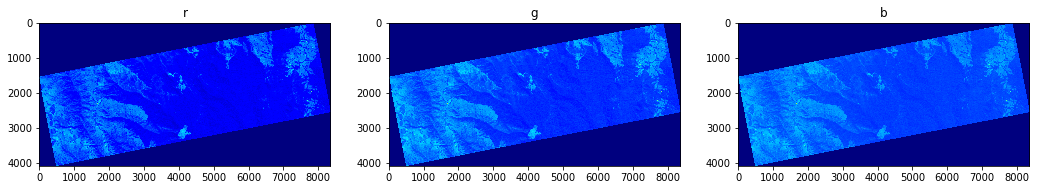

In [105]:
def rgbir_to_rgb(img_4band):
    """Convert an RGBIR image to RGB"""
    return img_4band[:,:,:3]

def load_image3(filename):
    """Return a 3D (r, g, b) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([b, g, r])
        
def get_mask(filename):
    """Return a 1D mask numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([mask])


def  plot_bands4(img,title="",i=0):
    fig = plt.figure(i)
    fig.set_size_inches(24, 3)
    r, g, b, nir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    fig.suptitle(title)
    for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(c)
        plt.imshow(x)
        
def plot_bands3(img,title="",i=0):
    fig = plt.figure(i)
    fig.set_size_inches(24, 5)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    fig.suptitle(title)
    for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(c)
        plt.imshow(x)
        
        
tiff_path = "/Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS.tif"        
rfbc = load_image4(tiff_path)
plot_bands3(rfbc)
plt.show()

#
import geopandas as gpd
df = gpd.read_file('/Users/brian/Downloads/gjq/export.geojson')
df.plot()
plt.show()

import mplleaflet
ax = df.plot()
mplleaflet.display(fig=ax.figure, crs=df.crs, tiles='cartodb_positron')

#
import sys
#!{sys.executable} -m pip uninstall rasterio
#!{sys.executable} -m pip install --pre -U rasterio
#!{sys.executable} -m pip install affine
#!{sys.executable} -m pip install fiona
#!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mplleaflet

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


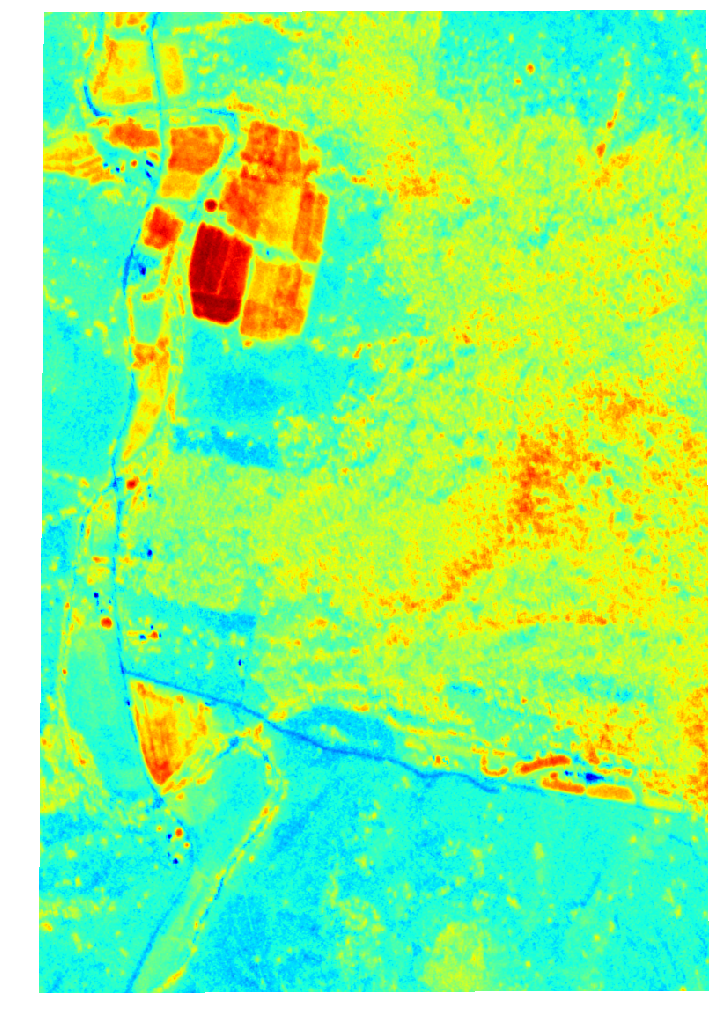

In [91]:
#rs = transform.rescale(fbc, 5/10) # this is skimage.transform
#rs.shape
nv = calc_nvdi(fbc)
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(nv)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


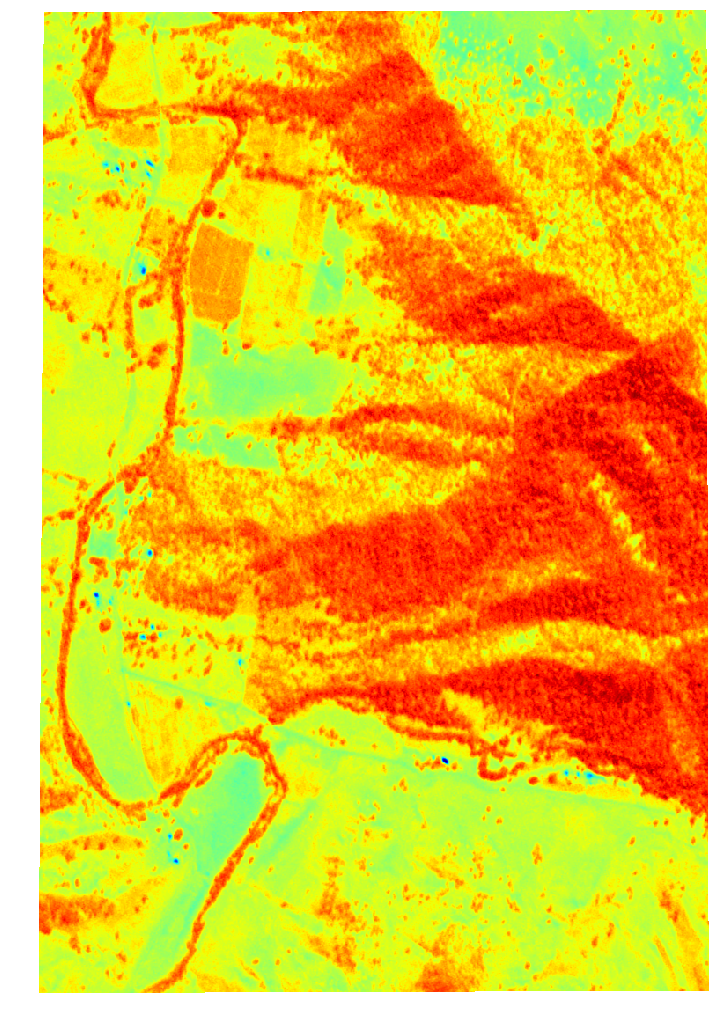

In [92]:
nv = calc_ecarr_using_band1(fbc)
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(nv)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


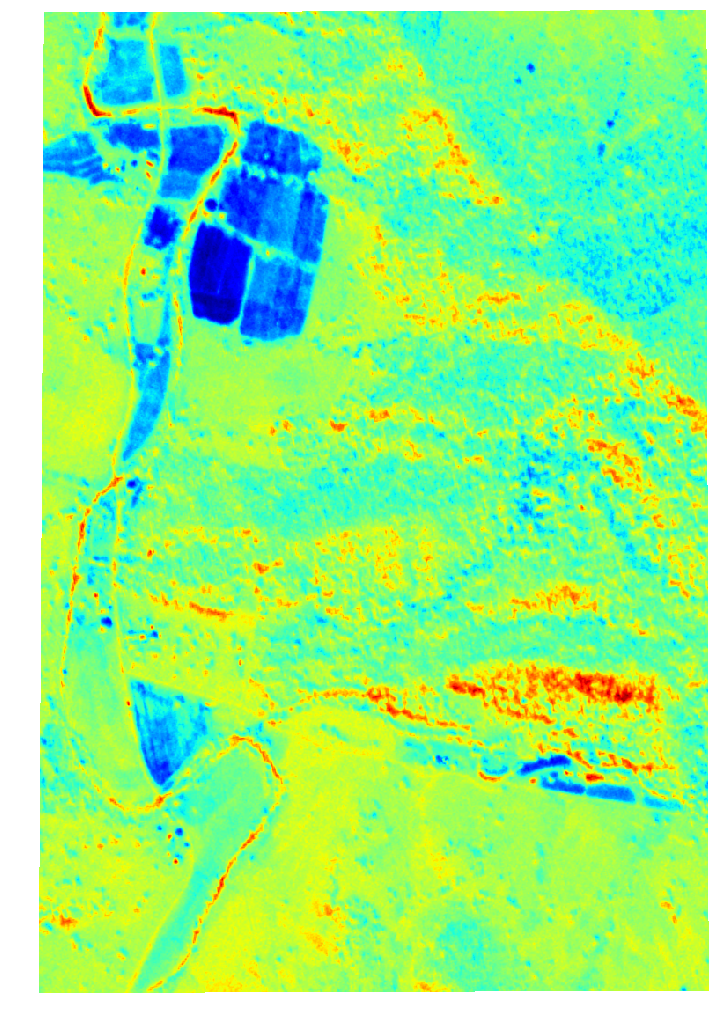

In [94]:
nw = calc_nwdi(fbc)
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(nw)
plt.show()